In [1]:
import numpy as np
import pymultinest

import matplotlib as mpl
import matplotlib.pyplot as plt
#%matplotlib inline

import json

import corner

import retrieval_base.auxiliary_functions as af

def read_results(prefix, n_params, w_set='K2166'):

    # Set-up analyzer object
    analyzer = pymultinest.Analyzer(
        n_params=n_params, 
        outputfiles_basename=prefix
        )
    stats = analyzer.get_stats()

    # Load the equally-weighted posterior distribution
    posterior = analyzer.get_equal_weighted_posterior()
    posterior = posterior[:,:-1]

    # Read the parameters of the best-fitting model
    bestfit = np.array(stats['modes'][0]['maximum a posterior'])

    PT = af.pickle_load(prefix+'data/bestfit_PT.pkl')
    Chem = af.pickle_load(prefix+'data/bestfit_Chem.pkl')

    m_spec = af.pickle_load(prefix+f'data/bestfit_m_spec_{w_set}.pkl')
    d_spec = af.pickle_load(prefix+f'data/d_spec_{w_set}.pkl')

    LogLike = af.pickle_load(prefix+f'data/bestfit_LogLike_{w_set}.pkl')

    try:
        Cov = af.pickle_load(prefix+f'data/bestfit_Cov_{w_set}.pkl')
    except:
        Cov = None

    int_contr_em           = np.load(prefix+f'data/bestfit_int_contr_em_{w_set}.npy')
    int_contr_em_per_order = np.load(prefix+f'data/bestfit_int_contr_em_per_order_{w_set}.npy')
    int_opa_cloud          = np.load(prefix+f'data/bestfit_int_opa_cloud_{w_set}.npy')

    f = open(prefix+'data/bestfit.json')
    bestfit_params = json.load(f)
    f.close()

    print(posterior.shape)
    return posterior, bestfit, PT, Chem, int_contr_em, int_contr_em_per_order, int_opa_cloud, m_spec, d_spec, LogLike, Cov, bestfit_params

In [2]:
prefix = './retrieval_outputs/fiducial_K_B_ret_9/test_'
w_set = 'K2166'
n_params = 28

res = read_results(prefix=prefix, n_params=n_params, w_set=w_set)
posterior, bestfit, PT, Chem, _, _, _, m_spec, d_spec, LogLike, Cov, bestfit_params = res
del res

  analysing data from ./retrieval_outputs/fiducial_K_B_ret_9/test_.txt
(2564, 28)


In [3]:
#pRT_atm = af.pickle_load(f'{prefix}data/pRT_atm_{w_set}.pkl')
pRT_atm = af.pickle_load(f'{prefix}data/pRT_atm_broad_{w_set}.pkl')

params_global = bestfit_params['params'].copy()
pRT_atm.params = params_global

import copy
# Compute a new model spectrum
m_spec = pRT_atm(Chem.mass_fractions, PT.temperature, params_global, get_contr=False, get_full_spectrum=True)
m_spec.wave_pRT_grid = copy.copy(pRT_atm.wave_pRT_grid)
m_spec.flux_pRT_grid = copy.copy(pRT_atm.flux_pRT_grid)

# Decrease the rotational broadening
params_local = params_global.copy()
#params_local['vsini'] = params_global['vsini']
params_local['vsini'] = 1
pRT_atm.params = params_local

# Set the abundances to 0
mf_local = Chem.mass_fractions.copy()
#mf_local['CH4_hargreaves_main_iso'] *= 0
#mf_local['H2O_pokazatel_main_iso'] *= 0
#mf_local['NH3_coles_main_iso'] *= 0
#mf_local['HCN_main_iso'] *= 0
#mf_local['CO2_main_iso'] *= 0

m_spec_local = pRT_atm(mf_local, PT.temperature, params_local, get_contr=False, get_full_spectrum=True)
m_spec_local.wave_pRT_grid = copy.copy(pRT_atm.wave_pRT_grid)
m_spec_local.flux_pRT_grid = copy.copy(pRT_atm.flux_pRT_grid)

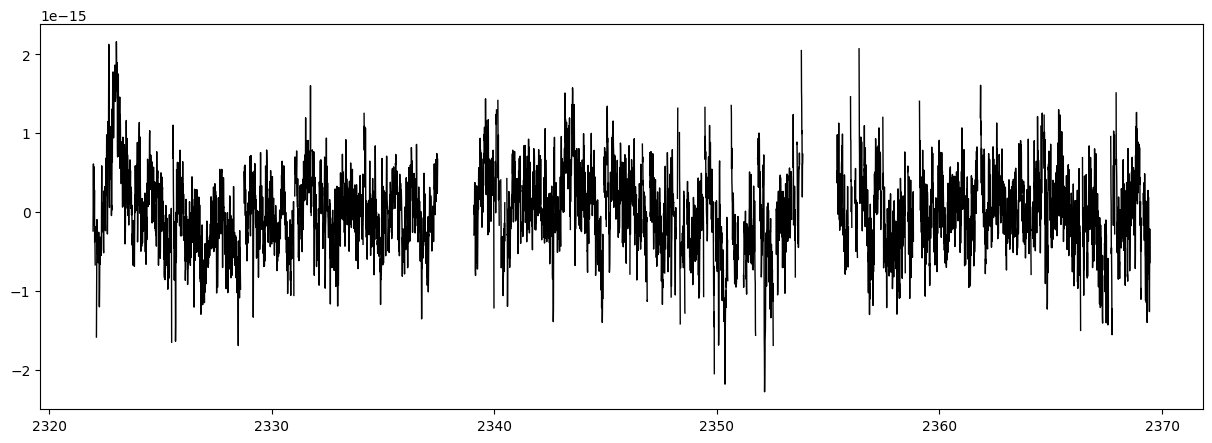

In [29]:
order = 5
det = [0,1,2]

f_local = 0.05

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(
    d_spec.wave[order,det].flatten(), 
    (d_spec.flux - LogLike.f[:,:,None]*m_spec.flux)[order,det].flatten(), c='k', lw=1
    )
ax.set_ylim(ax.get_ylim())
#ax.plot(
#    d_spec.wave[order,det].flatten(), 
#    f_local*(LogLike.f[:,:,None]*(m_spec_local.flux - m_spec.flux))[order,det].flatten(), c='C1', lw=2
#    )

plt.show()

In [13]:
from tqdm import tqdm
import petitRADTRANS.nat_cst as nc

def get_CCF(
        d_flux, rv=np.arange(-1000,1000+1e-6,1)
        ):
    
    CCF = np.nan * np.ones(
        (len(rv), d_spec.n_orders, d_spec.n_dets)
        )
    
    #d_wave = d_spec.wave * (1 - 17.9/(nc.c*1e-5))
    d_wave = d_spec.wave
    
    for i, rv_i in enumerate(tqdm(rv)):

        for j in range(d_spec.n_orders):
            
            # Shift the model spectrum
            m_wave = np.copy(m_spec_local.wave_pRT_grid[j])
            #m_wave *= (1 - params_global['rv']/(nc.c*1e-5))
            m_wave *= (1 + rv_i/(nc.c*1e-5))

            m_flux = np.copy(m_spec_local.flux_pRT_grid[j])
            # Subtract the global model?
            m_flux = m_flux - m_spec.flux_pRT_grid[j]

            # Interpolate onto the data wavelength grid
            m_flux = np.interp(
                d_wave[j], xp=m_wave, fp=m_flux
                )
            
            # Optimal scaling
            m_flux *= LogLike.f[j,:][:,None]

            for k in range(d_spec.n_dets):

                # Don't consider the nans
                mask_jk = d_spec.mask_isfinite[j,k]
                
                # Compute the covariance-weighted dot-product
                CCF[i,j,k] = np.dot(
                    m_flux[k,mask_jk], 
                    1/LogLike.beta[j,k]**2 * Cov[j,k].solve(d_flux[j,k,mask_jk])
                )

    return CCF, rv

CCF, rv = get_CCF(
    d_flux=(d_spec.flux - LogLike.f[:,:,None]*m_spec.flux), 
    )

100%|██████████| 2001/2001 [00:12<00:00, 156.86it/s]


-3.0


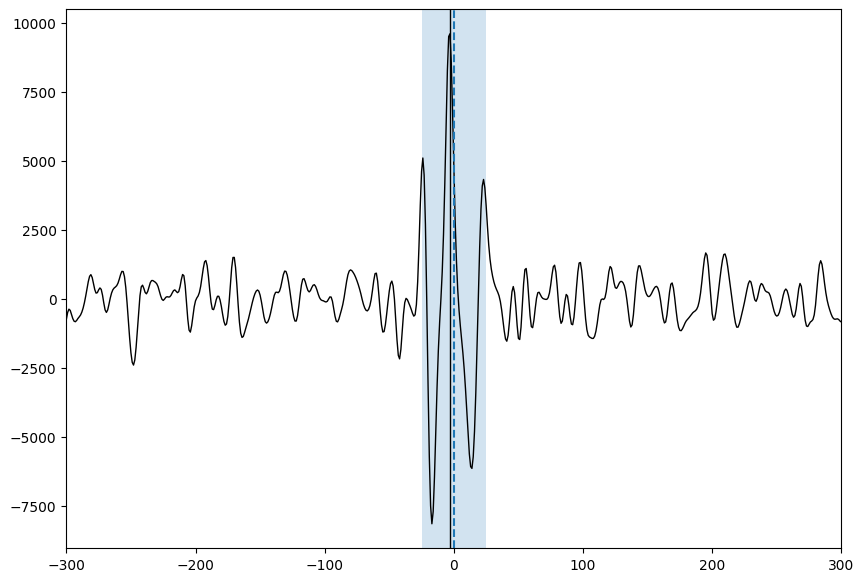

In [14]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(rv, CCF.sum(axis=(1,2)), c='k', lw=1)

idx = np.argmax(CCF.sum(axis=(1,2)))
ax.axvline(rv[idx], c='k', ls='-', lw=1)
print(rv[idx])

ax.axvline(0, c='C0', ls='--')
ax.axvspan(
    xmin=-params_global['vsini'], xmax=params_global['vsini'], 
    fc='C0', ec='none', alpha=0.2
    )

ax.set(xlim=(-300,300))
plt.show()

-1.0


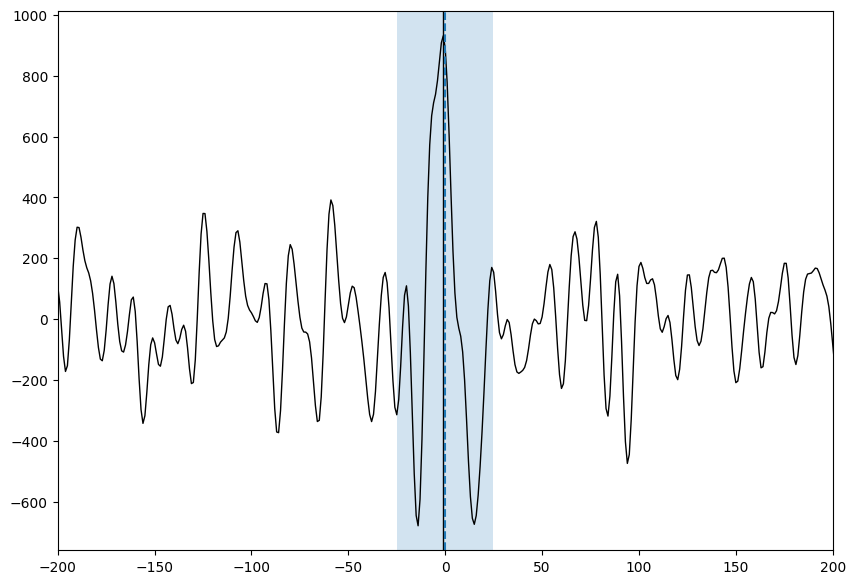

-3.0


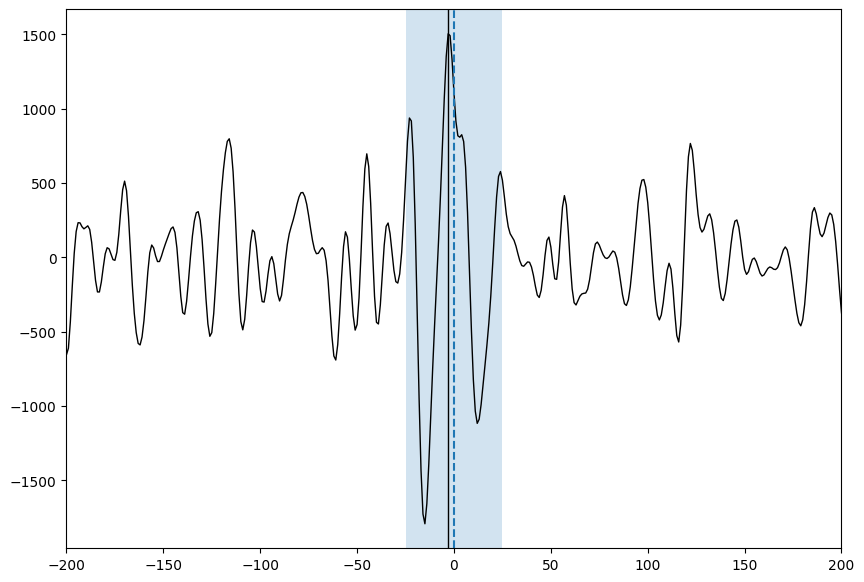

24.0


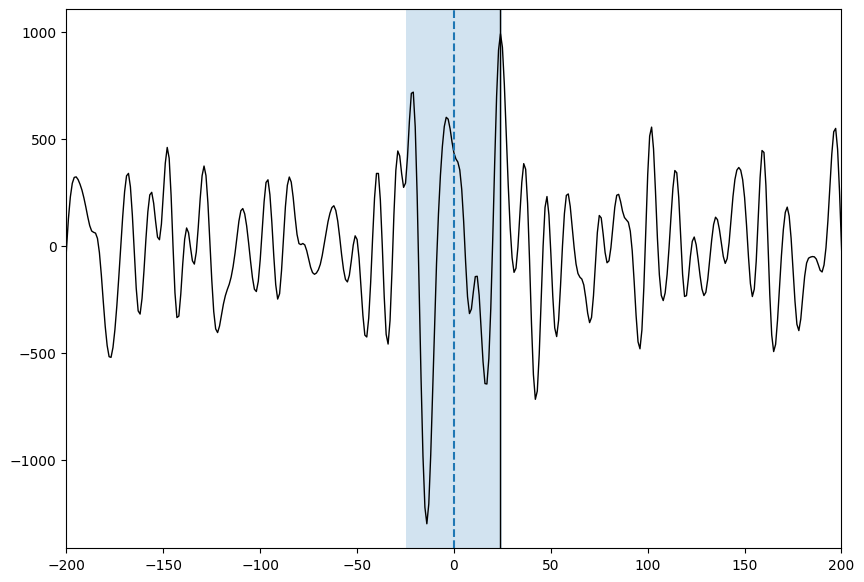

995.0


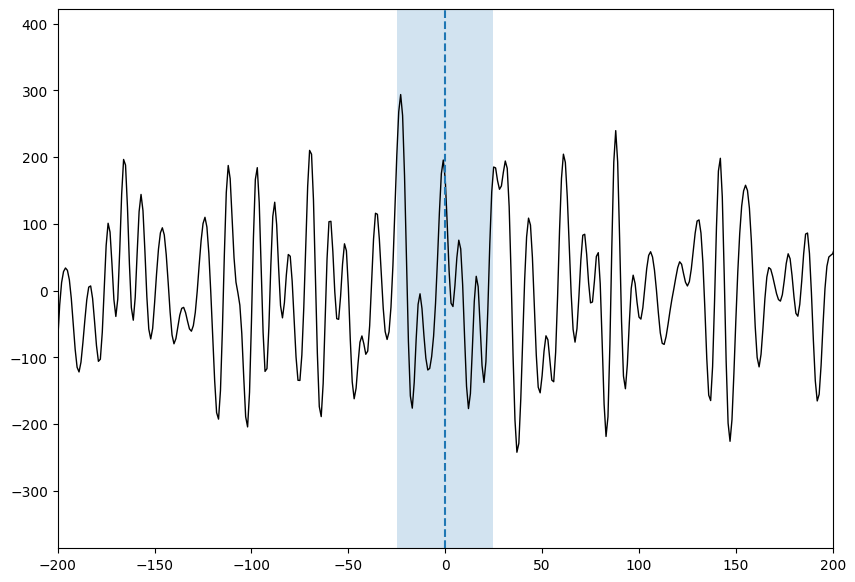

-2.0


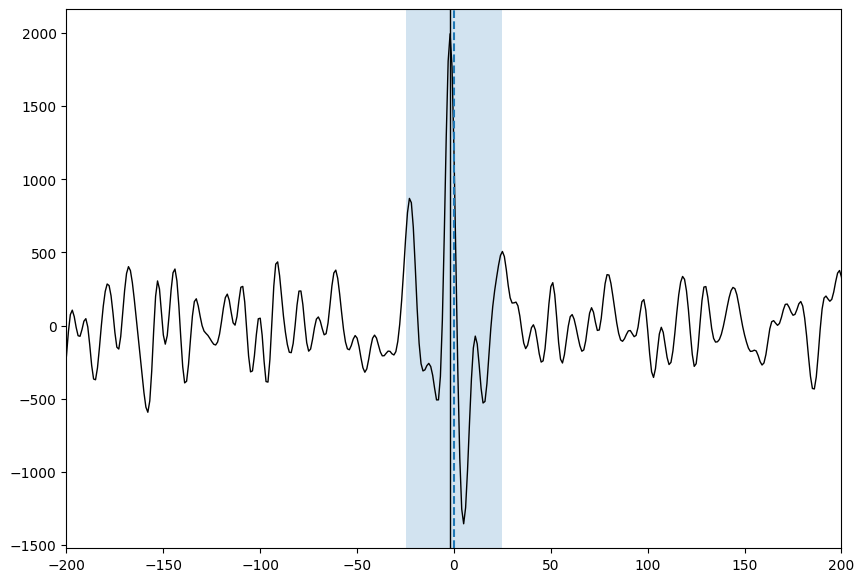

-2.0


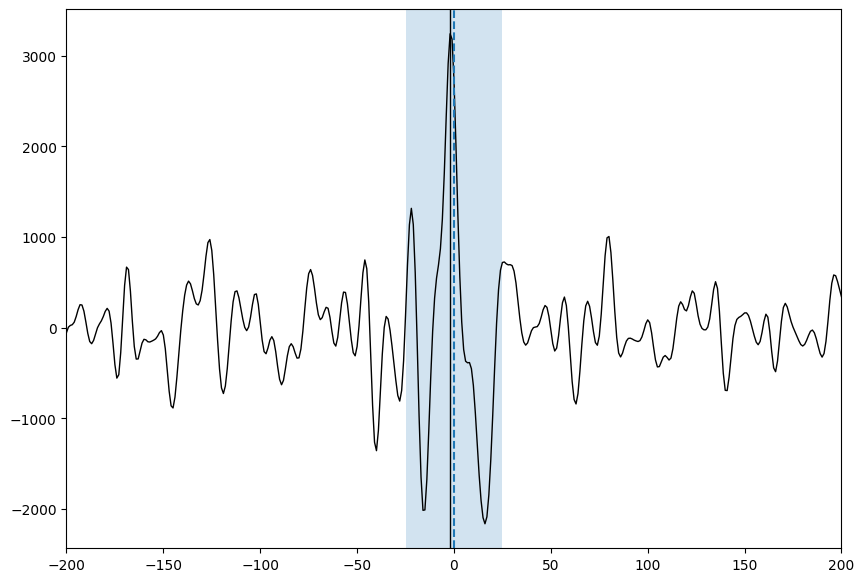

0.0


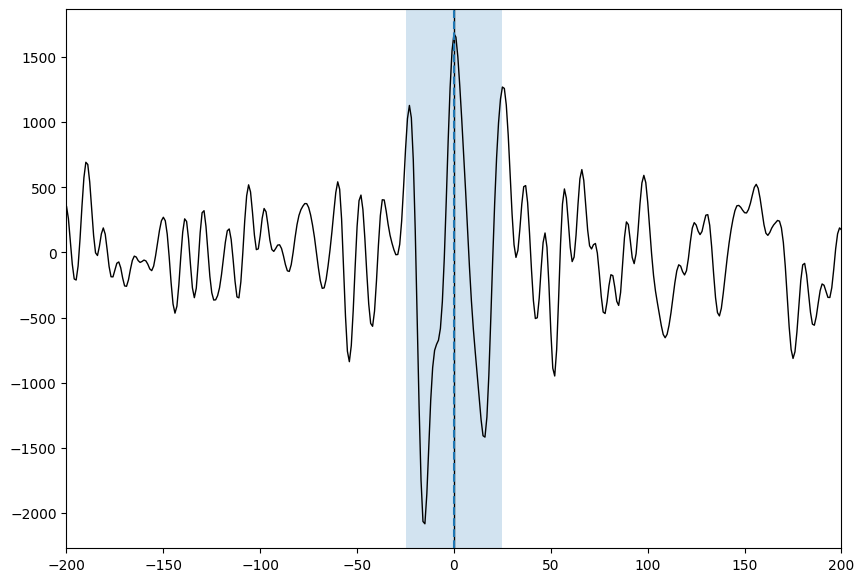

In [12]:
for i in range(d_spec.n_orders):

    fig, ax = plt.subplots(figsize=(10,7))
    ax.plot(rv, CCF[:,i,:].sum(axis=1), c='k', lw=1)

    idx = np.argmax(CCF[:,i,:].sum(axis=1))
    ax.axvline(rv[idx], c='k', ls='-', lw=1)
    print(rv[idx])

    ax.axvline(0, c='C0', ls='--')
    ax.axvspan(
        xmin=-params_global['vsini'], xmax=params_global['vsini'], 
        fc='C0', ec='none', alpha=0.2
        )

    ax.set(xlim=(-200,200))
    plt.show()